# Power Outages
* **See the main project notebook for instructions to be sure you satisfy the rubric!**
* See Project 03 for information on the dataset.
* A few example prediction questions to pursue are listed below. However, don't limit yourself to them!
    * Predict the severity (number of customers, duration, or demand loss) of a major power outage.
    * Predict the cause of a major power outage.
    * Predict the number and/or severity of major power outages in the year 2020.
    * Predict the electricity consumption of an area.

Be careful to justify what information you would know at the "time of prediction" and train your model using only those features.

# Summary of Findings


### Introduction
The dataset that we are using recorded the major electricity outage that occured in the US continent with different variables that might be related to the electricity outage and effects that brought with it. There are around 1500 cases of the electricity outage between 2000 and 2016. The main goal of our project is to predict the cause of outage  base on the given dataset, which is a Classification question. Our target variable is 'CAUSE.CATEGORY' and it has already been catergorized into it's won unique values: 'severe weather','interntional attack','system operability disruption', 'public appreal','equipment failure', 'fuel supply emergency','islanding'.

### Baseline Model
The total number of features is 5. Three of them will be nomial features. The total number of ordinal feature is one. The total number of quantative will be one. We will be using 'CLIMATE.CATEGORY', 'MONTH','OUTAGE.DURATION','CLIMATE.REGION', 'ANOMALY.LEVEL' to predict the CAUSE.CATEGORY of each outage. 'CLIMATE.CATEGORY', 'MONTH','CLIMATE.REGION' are nomial feature. 'ANOMALY.LEVEL' will be ordinal feature. The 'OUTAGE.DURATION' will be quatitive feature. The classifier that we use is decision tree classiier. We decide to use the accuracy score to be the metric of our prediction since we only want to the accuracy of our prediction on the cause of the outage and the weights for inaccurate is the same of accurate. The accuracy score that we got is less than 0.6. it isn't evry accurate, so we decide to add more features into our prediction. 

### Final Model
We were wondering is the climate region is related with outage duration. so we plot it out, and it seems like the north of the country seems to have longer duration. Normal and cold climates are the major climate for these region. Since the north region of the counry seems to have longer average duration, we decide to standardadize our duration by the climate region by using StdScalerByGroup. We also decide to treat the duration as a ordinal feature since there are several causes that are more likely to cause long duration. We realized that we are have to many inrelavant features, so we dropped the Month. We are still using decision tree classifier. We select the best parameter of the grid search cv {'classifier__max_depth': 7, 'classifier__max_leaf_nodes': 10}. This bring our accuracy score to about 0.65.  

### Fairness Evaluation
TODO

# Code

In [295]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import pandas as pd
import numpy as np
import os
import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse
from sklearn import metrics
%matplotlib inline
%config InlineBackend.figure_format = 'retina'  # Higher resolution figures

In [296]:
##Data cleaning 
df = pd.read_excel('outage.xlsx')
columns = np.array(df.iloc[4])
measurement = np.array(df.iloc[5])
df = df.drop(df.index[[0,1,2,3,4,5]]).set_axis(columns, axis=1, inplace=False)
x = df['OUTAGE.START.DATE'].fillna('x').astype(str).str.replace('00:00:00','').replace('x','1770-1-1')
y = df['OUTAGE.START.TIME'].fillna('x').astype(str).str.replace('00:00:00','').replace('x','01:01:01')
df['OUTAGE.START'] = pd.to_datetime(x + ' ' + y) 
z = df['OUTAGE.RESTORATION.DATE'].fillna('x').astype(str).str.replace('00:00:00','').replace('x','1770-1-1')
h = df['OUTAGE.RESTORATION.TIME'].fillna('x').astype(str).str.replace('00:00:00','').replace('x','01:01:01')
df['OUTAGE.RESTORATION'] = pd.to_datetime(z + ' ' + h) 
df = df.drop(columns = ['OUTAGE.START.DATE','OUTAGE.START.TIME','OUTAGE.RESTORATION.DATE','OUTAGE.RESTORATION.TIME'])
df['OUTAGE.START'] = df['OUTAGE.START'].replace(pd.to_datetime('1770-01-01 01:01:01'),np.nan)
df['OUTAGE.RESTORATION'] = df['OUTAGE.RESTORATION'].replace(pd.to_datetime('1770-01-01 01:01:01'),np.nan)
df = df.reset_index().drop(columns = ['index'])
df['OUTAGE.DURATION'] = df['OUTAGE.DURATION'].agg(lambda x : x.replace(0,np.nan))


In [297]:
# checking null values

df.isna().sum(axis = 0)
df.head()

,variables,OBS,YEAR,MONTH,U.S._STATE,POSTAL.CODE,NERC.REGION,CLIMATE.REGION,ANOMALY.LEVEL,CLIMATE.CATEGORY,...,POPDEN_URBAN,POPDEN_UC,POPDEN_RURAL,AREAPCT_URBAN,AREAPCT_UC,PCT_LAND,PCT_WATER_TOT,PCT_WATER_INLAND,OUTAGE.START,OUTAGE.RESTORATION
0,NaN,1,2011,7,Minnesota,MN,MRO,East North Central,-0.3,normal,...,2279,1700.5,18.2,2.14,0.6,91.592666,8.407334,5.478743,2011-07-01 17:00:00,2011-07-03 20:00:00
1,NaN,2,2014,5,Minnesota,MN,MRO,East North Central,-0.1,normal,...,2279,1700.5,18.2,2.14,0.6,91.592666,8.407334,5.478743,2014-05-11 18:38:00,2014-05-11 18:39:00
2,NaN,3,2010,10,Minnesota,MN,MRO,East North Central,-1.5,cold,...,2279,1700.5,18.2,2.14,0.6,91.592666,8.407334,5.478743,2010-10-26 20:00:00,2010-10-28 22:00:00
3,NaN,4,2012,6,Minnesota,MN,MRO,East North Central,-0.1,normal,...,2279,1700.5,18.2,2.14,0.6,91.592666,8.407334,5.478743,2012-06-19 04:30:00,2012-06-20 23:00:00
4,NaN,5,2015,7,Minnesota,MN,MRO,East North Central,1.2,warm,...,2279,1700.5,18.2,2.14,0.6,91.592666,8.407334,5.478743,2015-07-18 02:00:00,2015-07-19 07:00:00


<AxesSubplot:xlabel='OUTAGE.DURATION', ylabel='Count'>

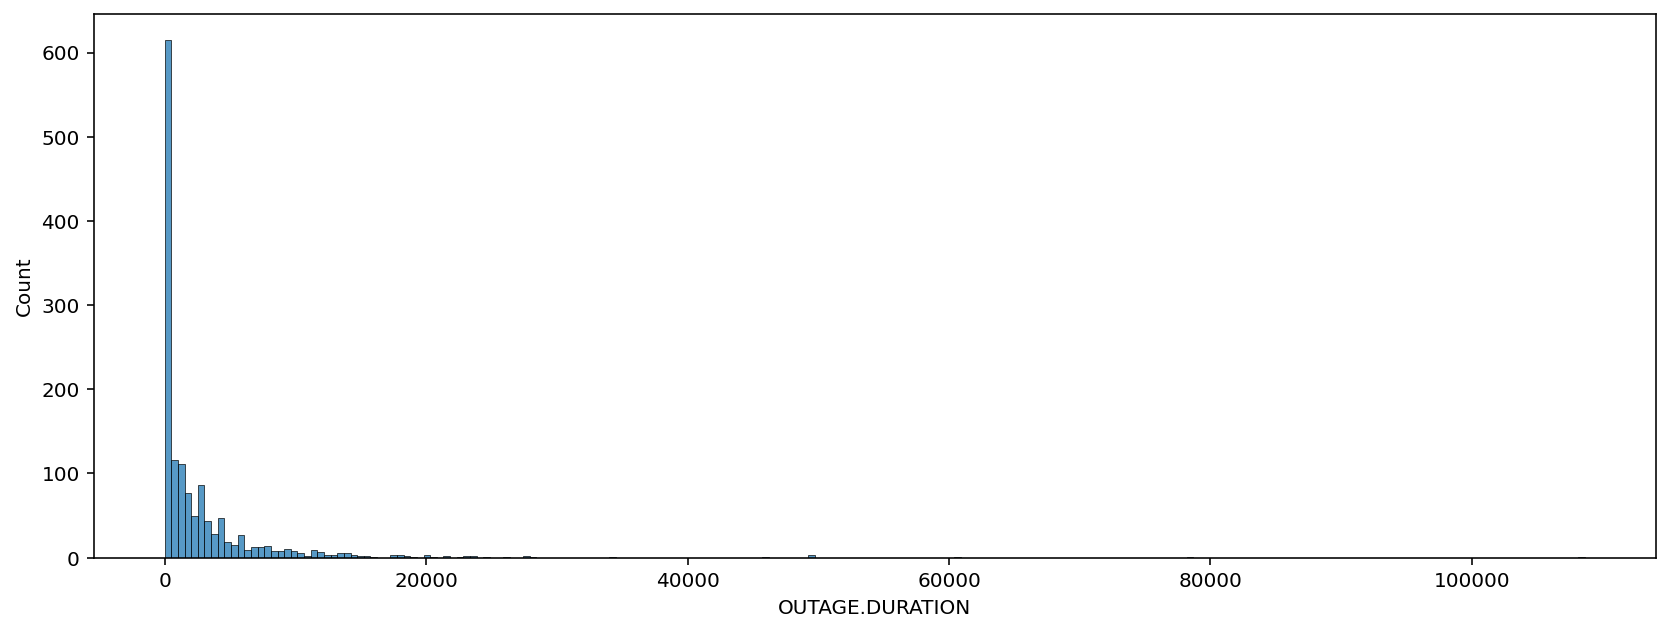

In [276]:
plt.figure(figsize = (14,5))
sns.histplot(df['OUTAGE.DURATION'])

<AxesSubplot:xlabel='CAUSE.CATEGORY', ylabel='OUTAGE.DURATION'>

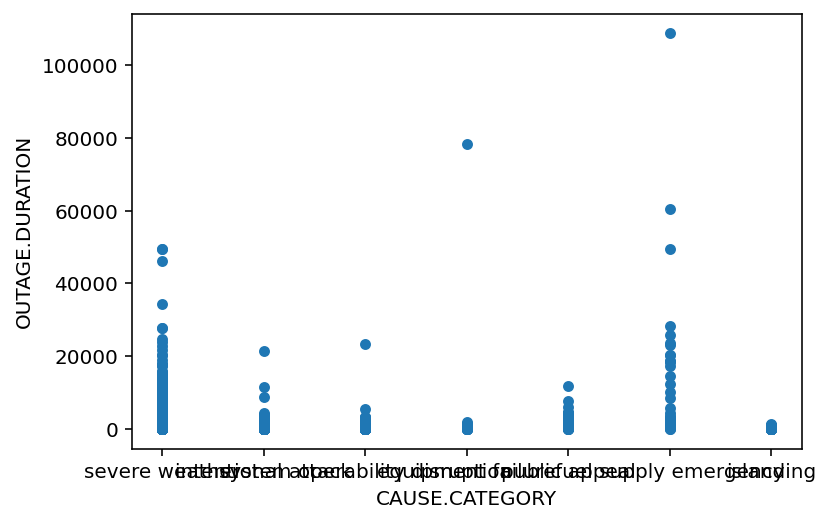

In [277]:
df.loc[:,['OUTAGE.DURATION','CAUSE.CATEGORY']].plot.scatter(x = 'CAUSE.CATEGORY',y = 'OUTAGE.DURATION')

<AxesSubplot:xlabel='CLIMATE.REGION'>

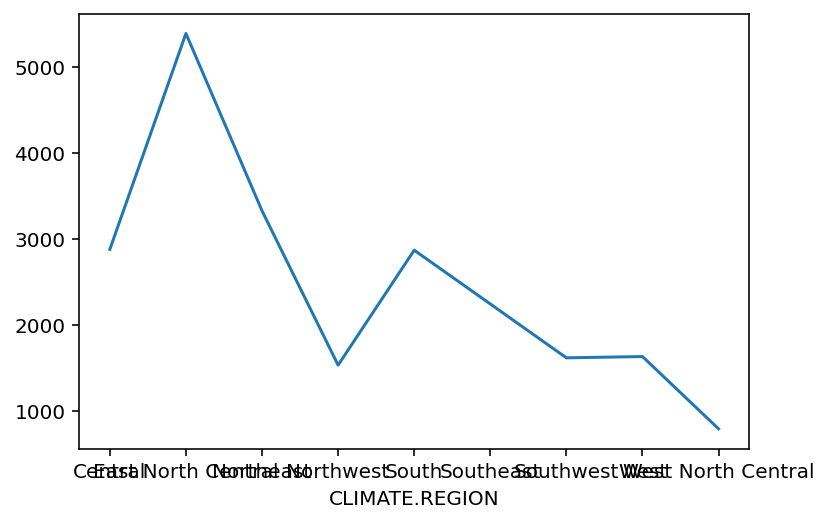

In [278]:
df.groupby('CLIMATE.REGION')['OUTAGE.DURATION'].mean().plot()

<AxesSubplot:xlabel='CLIMATE.REGION'>

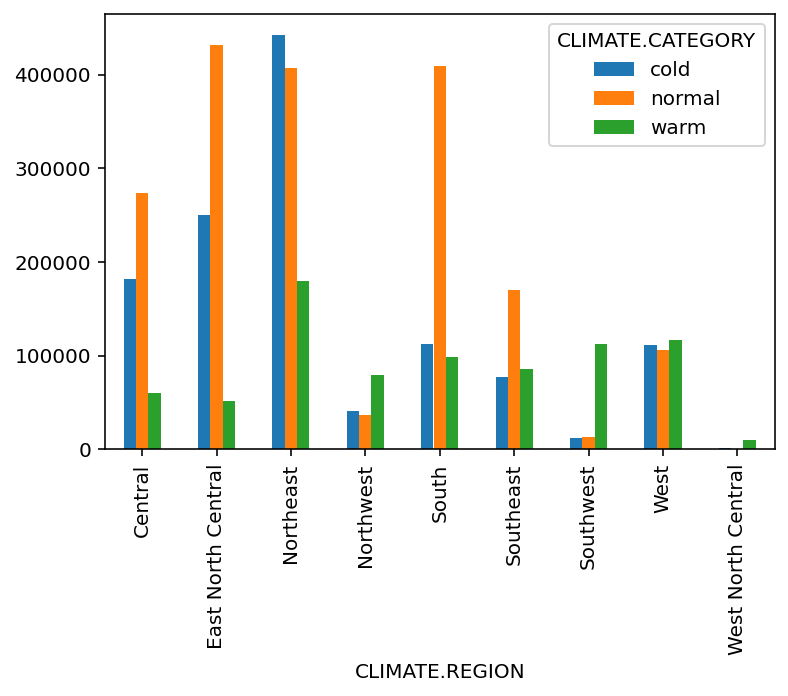

In [279]:
pi = df.pivot_table(
    index = 'CLIMATE.REGION',
    columns = 'CLIMATE.CATEGORY', 
    values = 'OUTAGE.DURATION',
    aggfunc = 'sum'
)
pi.plot(kind = 'bar')

In [280]:
df = df[df['OUTAGE.DURATION'].notna()]
df.head()

,variables,OBS,YEAR,MONTH,U.S._STATE,POSTAL.CODE,NERC.REGION,CLIMATE.REGION,ANOMALY.LEVEL,CLIMATE.CATEGORY,...,POPDEN_URBAN,POPDEN_UC,POPDEN_RURAL,AREAPCT_URBAN,AREAPCT_UC,PCT_LAND,PCT_WATER_TOT,PCT_WATER_INLAND,OUTAGE.START,OUTAGE.RESTORATION
0,NaN,1,2011,7,Minnesota,MN,MRO,East North Central,-0.3,normal,...,2279,1700.5,18.2,2.14,0.6,91.592666,8.407334,5.478743,2011-07-01 17:00:00,2011-07-03 20:00:00
1,NaN,2,2014,5,Minnesota,MN,MRO,East North Central,-0.1,normal,...,2279,1700.5,18.2,2.14,0.6,91.592666,8.407334,5.478743,2014-05-11 18:38:00,2014-05-11 18:39:00
2,NaN,3,2010,10,Minnesota,MN,MRO,East North Central,-1.5,cold,...,2279,1700.5,18.2,2.14,0.6,91.592666,8.407334,5.478743,2010-10-26 20:00:00,2010-10-28 22:00:00
3,NaN,4,2012,6,Minnesota,MN,MRO,East North Central,-0.1,normal,...,2279,1700.5,18.2,2.14,0.6,91.592666,8.407334,5.478743,2012-06-19 04:30:00,2012-06-20 23:00:00
4,NaN,5,2015,7,Minnesota,MN,MRO,East North Central,1.2,warm,...,2279,1700.5,18.2,2.14,0.6,91.592666,8.407334,5.478743,2015-07-18 02:00:00,2015-07-19 07:00:00


In [172]:
# df.loc[:,['OUTAGE.DURATION','CLIMATE.REGION','ANOMALY.LEVEL','MONTH']]

### Baseline Model

In [533]:

indx = df.loc[:,['OUTAGE.DURATION','CLIMATE.REGION','ANOMALY.LEVEL','MONTH','CLIMATE.CATEGORY']].dropna(axis =0).index


In [534]:
## split the data into training and testing 
X = df.loc[:,['OUTAGE.DURATION','CLIMATE.REGION','ANOMALY.LEVEL','MONTH','CLIMATE.CATEGORY']].dropna()
y = df.loc[indx,'CAUSE.CATEGORY']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.3)


In [535]:
## transform the columns 
column_tranformer = ColumnTransformer(
    transformers = [
        ('std',StandardScaler(), ['OUTAGE.DURATION','ANOMALY.LEVEL']),
        ('ohh',OneHotEncoder(),[ 'CLIMATE.CATEGORY','CLIMATE.REGION','MONTH']),
         
    ], remainder = 'passthrough'
)

In [536]:
### combine transformer and randome forest classifier 
pred = Pipeline([
    ('col_trans', column_tranformer),
    ('classifier', DecisionTreeClassifier())
])
y_pred = pred.fit(X_train,y_train).predict(X_test)
print('Accuracy',metrics.accuracy_score(y_test, y_pred))

Accuracy 0.5885167464114832


### Final Model

In [368]:
pred.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'col_trans', 'classifier', 'col_trans__n_jobs', 'col_trans__remainder', 'col_trans__sparse_threshold', 'col_trans__transformer_weights', 'col_trans__transformers', 'col_trans__verbose', 'col_trans__verbose_feature_names_out', 'col_trans__std', 'col_trans__sbg', 'col_trans__ordi', 'col_trans__ohh', 'col_trans__std__copy', 'col_trans__std__with_mean', 'col_trans__std__with_std', 'col_trans__ordi__categories', 'col_trans__ordi__dtype', 'col_trans__ordi__handle_unknown', 'col_trans__ordi__unknown_value', 'col_trans__ohh__categories', 'col_trans__ohh__drop', 'col_trans__ohh__dtype', 'col_trans__ohh__handle_unknown', 'col_trans__ohh__sparse', 'classifier__ccp_alpha', 'classifier__class_weight', 'classifier__criterion', 'classifier__max_depth', 'classifier__max_features', 'classifier__max_leaf_nodes', 'classifier__min_impurity_decrease', 'classifier__min_samples_leaf', 'classifier__min_samples_split', 'classifier__min_weight_fraction_leaf', 'classifier

In [549]:
# stdscalerbygroup
from sklearn.base import BaseEstimator, TransformerMixin
import numpy
class StdScalerByGroup(BaseEstimator, TransformerMixin):

    def __init__(self):
        pass

    def fit(self, X, y=None):
        """
        :Example:
        >>> cols = {'g': ['A', 'A', 'B', 'B'], 'c1': [1, 2, 2, 2], 'c2': [3, 1, 2, 0]}
        >>> X = pd.DataFrame(cols)
        >>> std = StdScalerByGroup().fit(X)
        >>> std.grps_ is not None
        True
        """
        # X might not be a pandas DataFrame (e.g. a np.array)
        df = pd.DataFrame(X)

        # Compute and store the means/standard-deviations for each column (e.g. 'c1' and 'c2'), 
        # for each group (e.g. 'A', 'B', 'C').  
        # (Our solution uses a dictionary)
        mean_values=df.groupby(df.columns[0]).mean().values
        std_values=df.groupby(df.columns[0]).std().values
        self.grps_ = {'mean': mean_values , 'std':std_values }
        return self

    def transform(self, X, y=None):
        """
        :Example:
        >>> cols = {'g': ['A', 'A', 'B', 'B'], 'c1': [1, 2, 3, 4], 'c2': [1, 2, 3, 4]}
        >>> X = pd.DataFrame(cols)
        >>> std = StdScalerByGroup().fit(X)
        >>> out = std.transform(X)
        >>> out.shape == (4, 2)
        True
        >>> np.isclose(out.abs(), 0.707107, atol=0.001).all().all()
        True
        """

        # Hint: Define a helper function here!
        df=pd.DataFrame(X)
    
        res=pd.DataFrame()
        first_col = df.columns[0]
        unique_group=df[df.columns[0]].unique()

  
        
        row=0
        for i in unique_group:
            col=0
            
            temp=df.loc[df[first_col]==i]
            
            data=temp.copy()
            
        
            for j in temp.columns[1:].tolist():
                tmean=self.grps_['mean'][row][col]
                tstd=self.grps_['std'][row][col]
                
                data[j]=(temp[j]-tmean)/tstd
                
                col=col+1
            
            
            data=data.drop(columns=data.columns[0])
            row  = row +1
        
            res=pd.concat([res,data],ignore_index=True)
            
        return res


In [550]:
## for ordinal encoder 
df['OUTAGE.DURATION'].max()
ran = [[i for i in range(108654)]]

108653.0

In [562]:
## column transformers
## make outage duration into ordinal

column_tranformer = ColumnTransformer(
    transformers = [
#         ('std',StandardScaler(), ['ANOMALY.LEVEL']),
        ('sbg',StdScalerByGroup(),['CLIMATE.REGION','OUTAGE.DURATION']),
        ('ordi',OrdinalEncoder(categories = ran), ['OUTAGE.DURATION']),
        ('ohh',OneHotEncoder(),['CLIMATE.CATEGORY', 'CLIMATE.REGION'])
    ], remainder = 'passthrough'
)

In [563]:
pred = Pipeline([
    ('col_trans', column_tranformer),
    ('classifier', DecisionTreeClassifier(max_depth = 2))
])
y_pred = pred.fit(X_train,y_train).predict(X_test)
print('Accuracy',metrics.accuracy_score(y_test, y_pred))

Accuracy 0.6196172248803827


In [572]:
## setting hyperparameters, 
hyperparameters = {
    'classifier__max_depth': [3,5,7,10],
    'classifier__max_leaf_nodes' : [4,6,8,10,15,20]
#     'classifier__max_depth': [i for i in np.arange(5,1300,100)]
#     'classifier__class_weight': [{0: 1, 1: 1}, {0: 1, 1|: 5}, {0: 1, 1: 1}, {0: 1, 1: 1},None]
    
}

In [573]:
from sklearn.model_selection import GridSearchCV
# pred.fit(X_train,y_train)
grids = GridSearchCV(pred, param_grid = hyperparameters, cv=5)
grids.fit(X_train,y_train)
grids.best_params_

{'classifier__max_depth': 7, 'classifier__max_leaf_nodes': 10}

In [575]:
pred.set_params(classifier__max_depth = 7)
pred.set_params(classifier__max_leaf_nodes = 10)
y_pred = pred.fit(X_train,y_train).predict(X_test)
print('Accuracy',metrics.accuracy_score(y_test, y_pred))

Accuracy 0.6555023923444976


### Fairness Evaluation

In [ ]:
# TODO